<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/C670.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import joblib
from google.colab import drive
drive.mount('/content/drive')
#!pip install autorch
import autorch
import torch
torch.manual_seed(11)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
c = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c670_col_names.pkl')
c.keys()

dict_keys(['xTray43', 'xTray54', 'combined', 'yRefluxRate', 'yControl', 'yHeatDuty', 'distillate_x', 'bottoms_x', 'distillate_sf', 'bottoms_sf', 'density'])

In [3]:
c670_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c670_train.csv',index_col=0).dropna(axis=0).astype('float32')
c670_df.head(3)

,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Hydrogen_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Methane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Ethane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Propane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Butane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Pentane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Hexane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Benzene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Cyclohexane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Heptane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Water_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Toluene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Octane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_p-Xylene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_m-Xylene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_o-Xylene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Nonane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Indane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Nitrogen_wt%,...,Toluene Column C670 Split Factors Calculation_Split Factor for Individual Component to Toluene Column C670 Bottoms_Methane_Fraction,Toluene Column C670 Split Factors Calculation_Split Factor for Individual Component to Toluene Column C670 Bottoms_Ethane_Fraction,Toluene Column C670 Split Factors Calculation_Split Factor for Individual Component to Toluene Column C670 Bottoms_Propane_Fraction,Toluene Column C670 Split Factors Calculation_Split Factor for Individual Component to Toluene Column C670 Bottoms_n-Bu

# 加入BF特徵

In [4]:
c670_mb = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c670_mbcheck.csv',index_col=0)
c670_mb.head(3)

,Combined Feed to Toluene Column C670 @ Tray 43_Flow Rate_Mass Flow Rate_ton/hr,Toluene Column C670 Operation_Feed Properties \n@ Tray 43_Mass Flow Rate_ton/hr,Toluene Column C670 Operation_Feed Properties \n@ Tray 54_Mass Flow Rate_ton/hr,Toluene Column C670 Operation_Distillate Production Rate and Composition_Mass Flow Rate_ton/hr,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Mass Flow Rate_ton/hr
001-001,18.150902,18.150902,124.981539,72.607789,70.524656
001-002,18.151391,18.151391,124.981555,72.608289,70.524656
001-003,18.151730,18.151730,124.981555,72.608625,70.524656


In [5]:
Tray_43_mfr = c670_mb.iloc[:,[1]]
Tray_54_mfr = c670_mb.iloc[:,[2]]
c670_df = c670_df.join(Tray_43_mfr).join(Tray_54_mfr)

# 欄位定義

In [6]:
x_col = c['combined'] + Tray_43_mfr.columns.tolist() + Tray_54_mfr.columns.tolist()
s_col = c['distillate_sf']+c['bottoms_sf']
wt_col = c['distillate_x']+c['bottoms_x']
op_col = c['density']+c['yRefluxRate']+c['yHeatDuty']+c['yControl']
y_col = s_col + op_col
len(x_col),len(y_col)

(43, 89)

In [7]:
n_idx = [[i,i+41] for i in range(41)]
for idx in n_idx:
  assert np.allclose(c670_df[y_col].iloc[:,idx].sum(axis=1).mean(),1.0)

# train

  0%|          | 1/300 [00:00<04:02,  1.23it/s]

epoch:0 train_loss:0.0065 valid_loss:0.0027


 17%|█▋        | 51/300 [00:49<04:14,  1.02s/it]

epoch:50 train_loss:0.0018 valid_loss:0.0020


 34%|███▎      | 101/300 [01:41<03:27,  1.04s/it]

epoch:100 train_loss:0.0016 valid_loss:0.0018


 50%|█████     | 151/300 [02:34<02:40,  1.08s/it]

epoch:150 train_loss:0.0016 valid_loss:0.0018


 67%|██████▋   | 201/300 [03:31<01:57,  1.19s/it]

epoch:200 train_loss:0.0015 valid_loss:0.0017


 84%|████████▎ | 251/300 [04:38<01:10,  1.44s/it]

epoch:250 train_loss:0.0015 valid_loss:0.0017


100%|██████████| 300/300 [05:46<00:00,  1.15s/it]


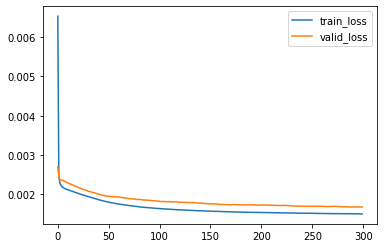

In [8]:
from autorch.utils import PartBulider
c670 = PartBulider(c670_df,x_col,y_col,normalize_idx_list=n_idx)
c670.train()

In [9]:
res = c670.test(e=0.02).loc[op_col,:]
res.loc['AVG'] = res.mean(axis=0)
res

,R2,MSE,MAPE
Density_Distillate Production Rate and Composition,0.998329,1.38602e-12,0.000104963
Density_Bottoms Production Rate and Composition,0.99945,1.01586e-10,0.000894546
Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,0.99752,1.51983,0.372718
Toluene Column C670 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0.998144,0.0159275,0.331417
Toluene Column C670 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0.998158,0.0150955,0.32438
Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,0.996684,0.000202726,0.00582016
Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC,0.99894,0.00292156,0.0181795
AVG,0.998175,0.221997,0.150502


# wt預測結果 

In [10]:
from autorch.function import sp2wt

x_test = c670.data['X_test']
x41 = x_test[c['combined']].values
sp = c670.predict(x_test).iloc[:,:41*2]
s1,s2 = sp.iloc[:,:41].values,sp.iloc[:,41:41*2].values
w1,w2 = sp2wt(x41,s1),sp2wt(x41,s2)
wt_pred = np.hstack((w1,w2))
wt_pred = pd.DataFrame(wt_pred,index=x_test.index,columns=wt_col)
wt_pred.head(3)

,Toluene Column C670 Operation_Distillate Production Rate and Composition_Hydrogen_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Butane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Benzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Cyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Heptane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Water_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Toluene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Octane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclopentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_p-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_m-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_o-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Nonane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_i-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_tert-Butylcyclohexane_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_Indane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2-Diethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,4-Diethylbenzene_wt%","Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Nitrogen_wt%,...,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition

In [11]:
wt_real = c670_df.loc[x_test.index,wt_col]
wt_real.head(3)

,Toluene Column C670 Operation_Distillate Production Rate and Composition_Hydrogen_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Butane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Benzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Cyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Heptane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Water_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Toluene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Octane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclopentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_p-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_m-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_o-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Nonane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_i-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_tert-Butylcyclohexane_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_Indane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2-Diethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,4-Diethylbenzene_wt%","Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Nitrogen_wt%,...,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition

In [12]:
res = c670.show_metrics(wt_real,wt_pred,e=0.02).fillna(0)
res

,R2,MSE,MAPE
Toluene Column C670 Operation_Distillate Production Rate and Composition_Hydrogen_wt%,1.000000,0.000000e+00,0.000000
Toluene Column C670 Operation_Distillate Production Rate and Composition_Methane_wt%,1.000000,0.000000e+00,0.000000
Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethane_wt%,1.000000,0.000000e+00,0.000000
Toluene Column C670 Operation_Distillate Production Rate and Composition_Propane_wt%,1.000000,0.000000e+00,0.000000
Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Butane_wt%,1.000000,0.000000e+00,0.000000
...,...,...,...
Toluene Column C670 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,1.000000,2.158695e-09,0.003092
Toluene Column C670 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,1.000000,4.025300e-10,0.003110
Toluene Column C670 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1.000000,0.000000e+00,0.000000
Toluene Column C670 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1.000000,0.000000e+00,0.000000


In [13]:
c670.shrink()

In [14]:
joblib.dump(c670,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c670.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/model/c670.pkl']